# **The seventh in-class-exercise (20 points in total, 10/21/2020)**

Question description: In the last in-class-exercise (exercise-06), you collected the titles of 100 articles about data science, natural language processing, and machine learning. The 100 article titles will be used as the text corpus of this exercise. Perform the following tasks:

## (1) (8 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Write your code here
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)







[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [28]:
pip install pyldavis

     |████████████████████████████████| 1.6MB 3.4MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=ed20b646a2958b3d52e7c91f495ba4fc6fed583ce279c85fb1efc179f6d8d284
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyldavis


In [6]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [58]:
# Import Dataset
import pandas as pd
df = pd.read_csv('/content/Inclass6.csv', encoding = 'ISO-8859-1')
#print(df.target_names.unique())
df.head()

,Abstract
0,Background
1,Clinical narratives represent the main form of...
2,NaN
3,Objective
4,The main aim of this study was to provide syst...


In [54]:
import re
from pprint import pprint
# Convert to list
data = df["Abstract"].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

TypeError: ignored

In [82]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['background']]


In [83]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['background']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [84]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


In [85]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['background']]


In [86]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [87]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('background', 1)]]

In [88]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [89]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.054*"language" + 0.045*"clinical" + 0.041*"natural" + 0.034*"processing" '
  '+ 0.033*"narrative" + 0.020*"unlock" + 0.020*"health" + 0.020*"evidence" + '
  '0.020*"make" + 0.017*"form"'),
 (1,
  '0.038*"full" + 0.038*"text" + 0.038*"freely" + 0.038*"available" + '
  '0.038*"online" + 0.038*"academic" + 0.003*"extract" + 0.003*"datum" + '
  '0.002*"task" + 0.002*"information"'),
 (2,
  '0.002*"use" + 0.002*"annotation" + 0.002*"learning" + 0.002*"utilize" + '
  '0.002*"small" + 0.002*"model" + 0.002*"dataset" + 0.002*"datum" + '
  '0.002*"text" + 0.002*"document"'),
 (3,
  '0.046*"background" + 0.003*"use" + 0.003*"study" + 0.003*"dataset" + '
  '0.002*"learning" + 0.002*"size" + 0.002*"document" + 0.002*"machine" + '
  '0.002*"thousand" + 0.002*"performance"'),
 (4,
  '0.031*"term" + 0.029*"search" + 0.026*"learn" + 0.025*"review" + '
  '0.025*"machine" + 0.022*"application" + 0.021*"use" + 0.018*"datum" + '
  '0.018*"extract" + 0.018*"follow"'),
 (5,
  '0.061*"knowledge" + 

In [90]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.054*"language" + 0.045*"clinical" + 0.041*"natural" + 0.034*"processing" '
  '+ 0.033*"narrative" + 0.020*"unlock" + 0.020*"health" + 0.020*"evidence" + '
  '0.020*"make" + 0.017*"form"'),
 (1,
  '0.038*"full" + 0.038*"text" + 0.038*"freely" + 0.038*"available" + '
  '0.038*"online" + 0.038*"academic" + 0.003*"extract" + 0.003*"datum" + '
  '0.002*"task" + 0.002*"information"'),
 (2,
  '0.002*"use" + 0.002*"annotation" + 0.002*"learning" + 0.002*"utilize" + '
  '0.002*"small" + 0.002*"model" + 0.002*"dataset" + 0.002*"datum" + '
  '0.002*"text" + 0.002*"document"'),
 (3,
  '0.046*"background" + 0.003*"use" + 0.003*"study" + 0.003*"dataset" + '
  '0.002*"learning" + 0.002*"size" + 0.002*"document" + 0.002*"machine" + '
  '0.002*"thousand" + 0.002*"performance"'),
 (4,
  '0.031*"term" + 0.029*"search" + 0.026*"learn" + 0.025*"review" + '
  '0.025*"machine" + 0.022*"application" + 0.021*"use" + 0.018*"datum" + '
  '0.018*"extract" + 0.018*"follow"'),
 (5,
  '0.061*"knowledge" + 

In [91]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.340459777319685

Coherence Score:  0.5792183899493487


In [72]:
!pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 193kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [73]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.8" 2020-07-14
OpenJDK Runtime Environment (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1)
OpenJDK 64-Bit Server VM (build 11.0.8+10-post-Ubuntu-0ubuntu118.04.1, mixed mode, sharing)


In [74]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

--2020-10-23 04:07:57--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.0MB/s    in 1.4s    

2020-10-23 04:07:58 (11.0 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/mallet.bat  
  inflating: mallet-2.0.8/bin/mallethon  
  inflating: mallet-2.0.8/bin/prepend-license.sh  
  inflating: mallet-2.0.8/bin/svmlight2vectors  
  inflating: mallet-2.0.8/bin/text2classi

In [75]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [76]:
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(19,
  [('work', 0.023311391555909604),
   ('make', 0.02329042807429458),
   ('money', 0.017001383589786593),
   ('pay', 0.015030816317974089),
   ('job', 0.012557125487400948),
   ('people', 0.012389417634480735),
   ('year', 0.011152572219194164),
   ('thing', 0.010523667770743365),
   ('time', 0.010481740807513311),
   ('give', 0.009349712800301875)]),
 (7,
  [('mail', 0.03421876321800186),
   ('post', 0.029312240927163523),
   ('send', 0.027197360629388375),
   ('information', 0.022206243126639033),
   ('list', 0.021466035022417732),
   ('address', 0.018462904999577024),
   ('include', 0.01681329836731241),
   ('internet', 0.015607816597580577),
   ('email', 0.015459774976736316),
   ('group', 0.015438626173758565)]),
 (14,
  [('image', 0.019769765008086766),
   ('software', 0.019179906764342117),
   ('version', 0.018609076205879555),
   ('server', 0.013814099514794025),
   ('file', 0.013795071829511939),
   ('program', 0.013566739606126914),
   ('include', 0.012957853677100182),


In [77]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [78]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


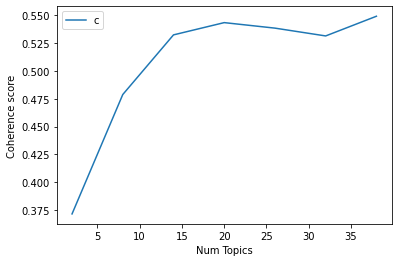

In [79]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [80]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3716
Num Topics = 8  has Coherence Value of 0.4787
Num Topics = 14  has Coherence Value of 0.5323
Num Topics = 20  has Coherence Value of 0.5433
Num Topics = 26  has Coherence Value of 0.5383
Num Topics = 32  has Coherence Value of 0.5313
Num Topics = 38  has Coherence Value of 0.549


In [81]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.018*"people" + 0.010*"israeli" + 0.010*"war" + 0.009*"attack" + '
  '0.009*"world" + 0.008*"kill" + 0.008*"turkish" + 0.008*"land" + '
  '0.008*"government" + 0.008*"armenian"'),
 (1,
  '0.045*"window" + 0.042*"problem" + 0.022*"line" + 0.021*"run" + '
  '0.020*"work" + 0.017*"set" + 0.015*"application" + 0.014*"screen" + '
  '0.013*"call" + 0.013*"find"'),
 (2,
  '0.035*"line" + 0.030*"number" + 0.029*"file" + 0.021*"read" + '
  '0.018*"follow" + 0.015*"program" + 0.015*"write" + 0.012*"entry" + '
  '0.011*"give" + 0.011*"open"'),
 (3,
  '0.027*"gun" + 0.012*"law" + 0.011*"state" + 0.011*"crime" + 0.010*"kill" + '
  '0.010*"weapon" + 0.010*"fire" + 0.009*"people" + 0.009*"make" + '
  '0.009*"case"'),
 (4,
  '0.011*"study" + 0.010*"problem" + 0.009*"food" + 0.008*"drug" + '
  '0.008*"doctor" + 0.008*"time" + 0.008*"effect" + 0.007*"eat" + '
  '0.007*"patient" + 0.007*"day"'),
 (5,
  '0.017*"power" + 0.016*"line" + 0.011*"ground" + 0.010*"current" + '
  '0.009*"water" + 0.009*

## (2) (8 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [60]:
# Write your code here
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix



In [62]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [65]:
def compute_coherence_values_lsa(dictionary, doc_term_matrix, doc_clean, start, limit, step):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [69]:
from gensim.test.utils import common_dictionary, common_corpus
from gensim.models import LsiModel

model_list_lsa, coherence_lsa = compute_coherence_values_lsa(id2word,corpus,data_lemmatized,start=2,limit=40,step=6)


NameError: ignored

In [70]:
optimal_model_lsa = model_list_lsa[3]
model_topics_lsa = optimal_model_lsa.show_topics(formatted=False)
pprint(optimal_model_lsa.print_topics(num_words=10))

NameError: ignored

## (3) (4 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [61]:
# Write your answer here (no code needed for this question)

"""

Out from the two LSA And LDA.
LSA is used for the matrix decomposition relating to the similar document outputs.
Thats used for the cosine similarity.
Here the LDA is completely vicevcersa.
It displays all the rows and columns in all the documents.
The drawbacks in LDA are all covered using the LSA.

"""

'\n\nOut from the two LSA And LDA.\nLSA is used for the matrix decomposition relating to the similar document outputs.\nThats used for the cosine similarity.\nHere the LDA is completely vicevcersa.\nIt displays all the rows and columns in all the documents.\nThe drawbacks in LDA are all covered using the LSA.\n\n'